In [ ]:
#import libraries
import torch
from torch import nn
from torchvision import transforms, datasets
from torchsummary import summary
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
#define the model class deriving from PyTorch’s on.Module. 
#This approach is like TensorFlow’s model subclassing. 
#Here, you defined the class name NeuralNetwork. 
#This class contains two elements:
#The __init__ method, which acts like the class constructor. You use this method to define the feedforward network. 
#Specifically, you flatten the input (reshape the image from (28, 28) to a 728-dimensional vector. 
#Then, you create the linear stack of layers. 
#It has the same structure as the network created with TensorFlow. 
#There are, of course, slight differences in naming conventions. You use Linear (PyTorch) instead of Dense (TensorFlow). 
#In PyTorch, you must use activation functions separately, right after the Linear layers.
#The forward method takes the input image, flattens it, and then passes it through the network to calculate the prediction (score array).

class_names = range(10);

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(28*28, 64),            
            nn.Tanh(),            
            nn.Dropout(.2),
            
            nn.Linear(64, 128),
            nn.Sigmoid(),
            nn.Dropout(.2),

            nn.Linear(128, len(class_names)),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits



In [ ]:
#initialize the model and display its summary:
model = NeuralNetwork();

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 64]          50,240
              Tanh-3                   [-1, 64]               0
           Dropout-4                   [-1, 64]               0
            Linear-5                  [-1, 128]           8,320
           Sigmoid-6                  [-1, 128]               0
           Dropout-7                  [-1, 128]               0
            Linear-8                   [-1, 10]           1,290
           Softmax-9                   [-1, 10]               0
Total params: 59,850
Trainable params: 59,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.23
Estimated Total Size (MB): 0.24
---------------------------------------------

In [ ]:
#load data

#When accessing the dataset, you can specify the transformations to apply to each item. 
#Here, you use ToTensor transform, which converts MNIST images to tensors and scales the images to the range 0-1.
#To load the data, you use the DataLoader utility class. 
#This class enables you to load multiple images at once. 
#You control the number of images to load using the batch_size parameter. 
#You set its value to 32, the same as TensorFlow’s default value for the fit method.


# Training data 
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

# Test data
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

# Dataloaders 
batch_size = 32

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

100%|██████████| 9912422/9912422 [00:00<00:00, 115981329.61it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 52011890.86it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35281740.02it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2765354.73it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
#specify the loss function, and the optimizer
#Similar to tensorflow, you use the CrossEntropyLoss, and use the Adam optimizer. 
#For the learning rate, you set 1e-3, which is the same value as the default in TensorFlow.

learning_rate = 1e-3;

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
#Then, you must define the method for training and evaluating your feedforward neural network. 
#This is equivalent to the fit method from TensorFlow.

#The first method, train_loop, uses the backpropagation algorithm to optimize the trainable parameters 
#to minimize the prediction error of the neural network. 
#The second method, test_loop, calculates the neural network 
#error using the test images and displays the accuracy and loss value. 

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (x, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    
    print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
#now invoke those methods to train and evaluate the model. Like TensorFlow, you use ten epochs:
#model gives 95% accuracy

epochs = 10

for t in range(epochs):
    print(f"Epoch {t+1}:")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)

Epoch 1:
Accuracy: 91.5%, Avg loss: 1.555247 

Epoch 2:
Accuracy: 93.1%, Avg loss: 1.533483 

Epoch 3:
Accuracy: 93.5%, Avg loss: 1.530424 

Epoch 4:
Accuracy: 94.4%, Avg loss: 1.519677 

Epoch 5:
Accuracy: 94.5%, Avg loss: 1.518376 

Epoch 6:
Accuracy: 95.0%, Avg loss: 1.513600 

Epoch 7:
Accuracy: 95.0%, Avg loss: 1.512689 

Epoch 8:
Accuracy: 94.8%, Avg loss: 1.514118 

Epoch 9:
Accuracy: 95.3%, Avg loss: 1.510094 

Epoch 10:
Accuracy: 94.9%, Avg loss: 1.514308 



In [ ]:
# get the test images with their labels:
test_images, test_labels = next(iter(test_dataloader))

# Recognize digits
prediction_result = model(test_images);

# Get predicted labels
predicted_labels = prediction_result.argmax(1);

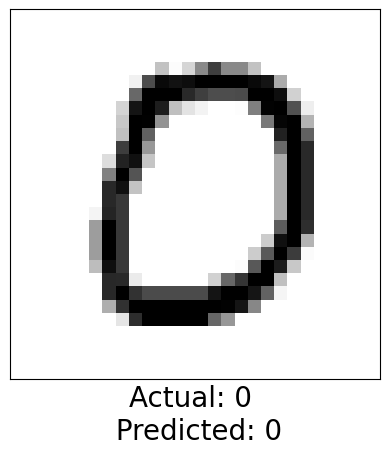

In [ ]:
# Get randomly selected image for preview
preview_image_index = np.random.randint(0, test_images.shape[0] - 1)

plt.figure()
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(test_images[preview_image_index][0].numpy(), cmap=plt.cm.binary)

plt.xlabel(f"Actual: {test_labels[preview_image_index]} \n Predicted: {predicted_labels[preview_image_index]}", fontsize=20);